# An example of a data pipeline written in datajoint

Datajoint is a tool to describe relational databases in python or matlab. It allows scientists, who are often not very experienced with databases, to communication with a SQL database. Some more info can be found here:

https://tutorials.datajoint.io/

https://docs.datajoint.io/python/

In [1]:
import datajoint as dj
import pylab as pl
import numpy as np
from scipy import stats
%matplotlib inline
# Set.drop()

After installing a local SQL server [like MariaDB] you should be able to connect to it.

In [2]:
# added by LF
dj.config['database.host'] = "127.0.0.1"
dj.config['database.user'] = "root"
dj.config['database.password'] = "tutorial"
dj.conn()

Connecting root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

## 1) Defining the relational structure of the database

Define the schema to work in

In [3]:
schema = dj.schema('lfeng_prb3')

And the relational structure of the database. This database contains users that run experiments. Every experiment contains a data set with datapoints; these datapoints are analyzed and the result saved back in the database.

There are four allowed types of tables: Lookup, Manual, Imported and Part. The construction of the database is done by the definitions in the definition string. Lookup and Manual allow to specify all relevant components. Imported and computed run a function to populate the database automatically

In [4]:
@schema
class User(dj.Lookup):
    definition = """
    # users in the lab
    username : varchar(20)      # user in the lab
    ---
    first_name  : varchar(20)   # user first name
    last_name   : varchar(20)   # user last name
    """
    contents = [
        ['Angus', 'Angus', 'Macguyver'],
        ['John', 'John', 'Doe'],
    ]

@schema
class Experiment(dj.Manual):
    definition = """ # A simple experiment.
    -> User
    experiment : int    # allowed here are sql datatypes.
    ----
    """
    
    
@schema
class Set(dj.Imported):
    definition = """
    # A set of datapoints
    -> Experiment
    -----
    """

    class DataPoint(dj.Part):
        definition = """
        # Collected data.
        -> Set
        datapoint : int
        -----
        time : double
        voltage : float
        """
        
    # _make_tuples function to read data from txt file
    def _make_tuples(self, key):
        # read raw data
        data_file = "./data/{username}_experiment_{experiment}.dat".format(**key)
        print ('reading data : '+data_file)
        Vtrace  = np.loadtxt(data_file)
        tbins   = np.arange(0, 60, 0.00005) # 1 min recording with 50mu s sampling
        self.insert1(key)
        # extract spikes
        threshold = -40
        above = (Vtrace < threshold)
        spikes = above[1:] < above[0:-1]
        spikeTimes = tbins[np.where(spikes)]
        spikeVoltages = Vtrace[np.where(spikes)]
        
        b = []
        n = spikeVoltages.size
        for i in range(n):
            b.append(dict(key, datapoint=i, time=spikeTimes[i], voltage=spikeVoltages[i]))
        self.DataPoint().insert(b)
        


Datajoint allows to plot an entity relationship diagram. This shows explicitly what we have just described:

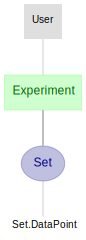

In [5]:
dj.ERD(schema)

The different colors indicate different table types. Gray is lookup, green is manual, blue is Imported and red (which we will see below) is computed. This entity relationship diagram describes how data is ultimately organized in the relational database. The next step is the population of the database with data.

## 2) Generate content for the database

The first think to enter into the databse are two experimenters, and their first experiment. With datajoint, we use the method .insert()

In [6]:
# Experiment().insert((['Angus',1],['John',1]), skip_duplicates = True)
Experiment().insert((['Angus',0], ['Angus',1], ['Angus',2],\
                     ['John',0], ['John',1], ['John',2], ['John',3], ['John',4]), skip_duplicates = True)

In [7]:
Experiment() #Shows the current content of the database

username user in the lab,experiment allowed here are sql datatypes.
Angus,0
Angus,1
Angus,2
John,0
John,1
John,2
John,3
John,4


Now that we have two experiments defined, we can populate the datasets for the experiment. This is done with the .populate() command.

In [8]:
Set().populate()

reading data : ./data/Angus_experiment_0.dat
reading data : ./data/Angus_experiment_1.dat
reading data : ./data/Angus_experiment_2.dat
reading data : ./data/John_experiment_0.dat
reading data : ./data/John_experiment_1.dat
reading data : ./data/John_experiment_2.dat
reading data : ./data/John_experiment_3.dat
reading data : ./data/John_experiment_4.dat


In [9]:
Set() # Now there are two datasets in the database

username user in the lab,experiment allowed here are sql datatypes.
Angus,0
Angus,1
Angus,2
John,0
John,1
John,2
John,3
John,4


In [10]:
Set().DataPoint() # With a set of datapoints

username user in the lab,experiment allowed here are sql datatypes.,datapoint,time,voltage
Angus,0,0,0.03765,-102.037
Angus,0,1,0.36705000000000004,-41.8517
Angus,0,2,0.3674,-93.4191
Angus,0,3,0.75905,-87.9921
Angus,0,4,1.38615,-40.4541
Angus,0,5,1.3865500000000002,-92.2962
Angus,0,6,1.5290000000000001,-92.6006
Angus,0,7,2.4852000000000003,-92.7949
Angus,0,8,3.03125,-95.9445
Angus,0,9,4.1418,-89.1101


One of the reasons that datajoint is popular is that it allows users to make SQL queries without even noticing it, e.g.

In [11]:
Experiment() & 'username = "Angus"'

username user in the lab,experiment allowed here are sql datatypes.
Angus,0
Angus,1
Angus,2


# 3) Compute in the database.

First, we add a new table to the database that fits a line

In [12]:
@schema
class LogGaussianFit(dj.Computed):
    definition = """
    # calculates the logGaussianFit
    -> Set
    -----
    mu : float
    std : float
    denom : float
    """
    
    #
    def _make_tuples(self, key):
        data  = (Set().DataPoint() & key)
        spikeTimes, voltage = data.fetch('time','voltage')
        ISI = np.diff(spikeTimes)
        
        ISIhist = pl.hist(ISI*1000, 30)
        import scipy.optimize as opt
        import scipy as sc

        def normpdf(x, mu, sd, denom):
            num = np.exp(-(x-mu)**2/(2*sd*sd))
            return num/denom

        probabilities = ISIhist[0]/np.sum(ISIhist[0])
        distance_between_spikes = ISIhist[1][:-1]

        popt, pcov = opt.curve_fit(normpdf, np.log(distance_between_spikes), probabilities)
        self.insert1(dict(key, mu = popt[0], std = popt[1], denom = popt[2]))
        
    

In [13]:
@schema
class PoissonianFit(dj.Computed):
    definition = """
    # calculates the logGaussianFit
    -> Set
    -----
    mu : float
    denom : float
    """
    
    #
    def _make_tuples(self, key):
        data  = (Set().DataPoint() & key)
        spikeTimes, voltage = data.fetch('time','voltage')
        ISI = np.diff(spikeTimes)
        
        ISIhist = pl.hist(ISI*1000, 30)
        import scipy.optimize as opt
        import scipy as sc
        import scipy.special

        def poissonpdf(x, mu, denom):
            num = np.exp(-mu)*(mu**x)/scipy.special.factorial(x)
            return num/denom

        probabilities = ISIhist[0]/np.sum(ISIhist[0])
        distance_between_spikes = ISIhist[1][:-1]

        
        # define valid index
#         valid_index =  (distance_between_spikes > 1e-3)*(np.logical_not(np.isinf(probabilities)))\
#                 *(np.logical_not(np.isnan(probabilities)))
#         probabilities           = probabilities[valid_index]
#         distance_between_spikes = distance_between_spikes[valid_index]

#         print (np.log(distance_between_spikes))
        popt, pcov = opt.curve_fit(poissonpdf, distance_between_spikes, probabilities)
        self.insert1(dict(key, mu = popt[0], denom = popt[1]))

Check that it appeared in the entity relationship diagram:

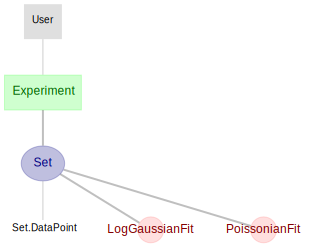

In [14]:
dj.ERD(schema)

After the definition we can call the populate function and read out the results

username user in the lab,experiment allowed here are sql datatypes.,mu,std,denom
Angus,0,1.82609,2.26906,3.67541
Angus,1,0.829672,2.76161,4.1453
Angus,2,1.31361,2.22562,2.26519
John,0,0.795074,2.83046,5.08225
John,1,-2.20796,1.13614,3.22324
John,2,1.02491,2.42935,2.38677
John,3,1.15708,2.58668,4.45303
John,4,1.22225,2.45943,3.67372


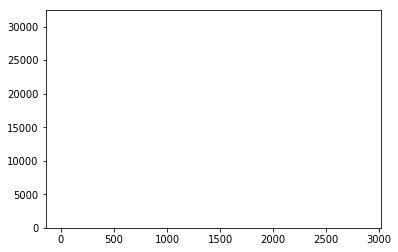

In [15]:
LogGaussianFit().populate()
LogGaussianFit()

/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power
/Users/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encount

username user in the lab,experiment allowed here are sql datatypes.,mu,denom
Angus,0,1.40084,1.84277
Angus,1,1.12428,1.96463
Angus,2,1.32793,1.47608
John,0,1.59755,1.65991
John,1,0.125008,2.49281
John,2,1.01651,1.47023
John,3,1.53831,1.87745
John,4,1.4961,1.67829


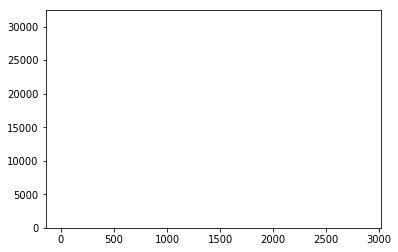

In [16]:
PoissonianFit().populate()
PoissonianFit()

If you use a database management tool, like Sequel Pro, or you connect to the database, you should be able to see the data directly.

In [17]:
LogGaussianFit().fetch('mu') # mean of Gaussian fits

array([ 1.82609 ,  0.829672,  1.31361 ,  0.795074, -2.20796 ,  1.02491 ,
        1.15708 ,  1.22225 ])

In [18]:
list1, list2 = Experiment().fetch('username', 'experiment')
Nexp = len(list2)
for i in range(Nexp):
    key = {'username': list1[i], 'experiment': list2[i]}
    data  = (Set().DataPoint() & key)
    spikeTimes, voltage = data.fetch('time','voltage')
    if spikeTimes.size >= 50:
        print('Experiment with at leat 50 spikes: {username} on {experiment}'.format(**key))

Experiment with at leat 50 spikes: Angus on 0
Experiment with at leat 50 spikes: Angus on 1
Experiment with at leat 50 spikes: Angus on 2
Experiment with at leat 50 spikes: John on 0
Experiment with at leat 50 spikes: John on 1
Experiment with at leat 50 spikes: John on 2
Experiment with at leat 50 spikes: John on 3
Experiment with at leat 50 spikes: John on 4
